<a href="https://colab.research.google.com/github/Saideepthimolugari25/Codsoft/blob/main/WUS_Blood_Group_Detection_Using_Fingerprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset URL: https://www.kaggle.com/datasets/rajumavinmar/finger-print-based-blood-group-dataset
License(s): unknown
 91% 53.0M/58.1M [00:00<00:00, 193MB/s]
100% 58.1M/58.1M [00:00<00:00, 187MB/s]
Found 6000 files belonging to 8 classes.
Detected classes: 8, Class counts: Counter({1: 1009, 6: 852, 3: 761, 5: 741, 7: 712, 2: 708, 4: 652, 0: 565})
Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 475ms/step - accuracy: 0.4534 - loss: 6.6670 - val_accuracy: 0.8025 - val_loss: 3.8858 - learning_rate: 0.0010
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 468ms/step - accuracy: 0.7604 - loss: 3.5613 - val_accuracy: 0.7321 - val_loss: 2.6599 - learning_rate: 0.0010
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 466ms/step - accuracy: 0.8101 - loss: 2.2501 - val_accuracy: 0.7734 - val_loss: 1.8814 - learning_rate: 0.0010
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 463ms/step - accuracy: 0.7960 - loss: 1.7594 - val_accuracy: 0.7467 - val_loss: 1.7382 - learning_rate: 0.0010
Epoch 5/50
131/131 ━━━━━━━━━━━━━

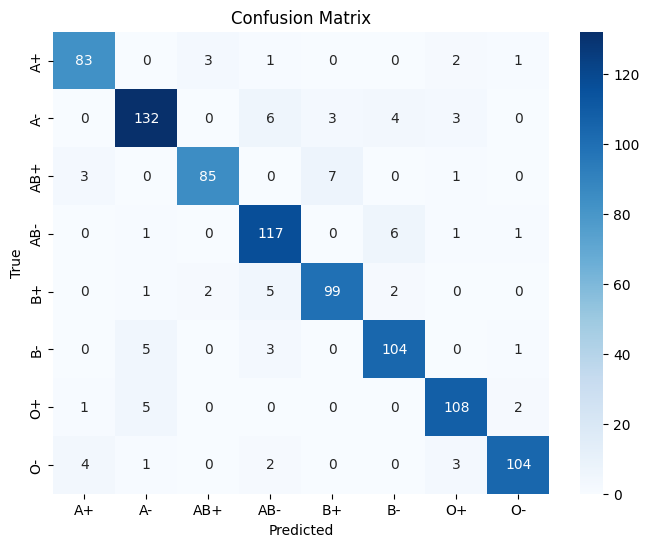

Model saved as HDF5 format.


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up Kaggle API
os.environ["KAGGLE_USERNAME"] = "saideepthimolugari"
os.environ["KAGGLE_KEY"] = "0552c8e61f2e880d75d911be689d5037"

# Install Kaggle and download dataset
!pip install kaggle
!kaggle datasets download -d rajumavinmar/finger-print-based-blood-group-dataset
!unzip -q finger-print-based-blood-group-dataset.zip -d /content/dataset/

# Import TensorFlow & other ML libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define constants
BATCH_SIZE = 32
IMAGE_SIZE = (64, 64)
dataset_path = '/content/dataset/dataset_blood_group'

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
)

# Analyze class distribution
class_names = dataset.class_names
num_classes = len(class_names)  # Ensure correct number of classes
class_counts = Counter()
for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1

print(f"Detected classes: {num_classes}, Class counts: {class_counts}")

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=30.0,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# Define improved CNN model
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model()

# Callbacks for better training
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    verbose=1,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model
y_true = []
y_pred = []
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate classification report
unique_labels = sorted(set(y_true) | set(y_pred))
report = classification_report(y_true, y_pred, labels=unique_labels, target_names=[class_names[i] for i in unique_labels])
print(report)

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[class_names[i] for i in unique_labels], yticklabels=[class_names[i] for i in unique_labels])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the model
model.save('blood_group_model_v2.h5')
print("Model saved as HDF5 format.")

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,581,978 (25.11 MB)

 Trainable params: 2,193,672 (8.37 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 4,387,346 (16.74 MB)

In [ ]:

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.9099 - loss: 0.4360
Final Training Accuracy: 94.70%
Final Validation Accuracy: 92.52%
Test Accuracy: 91.23%


In [ ]:
# Evaluate model on test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_acc * 100:.2f}%")


29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9017 - loss: 0.4308
Test Accuracy: 90.68%


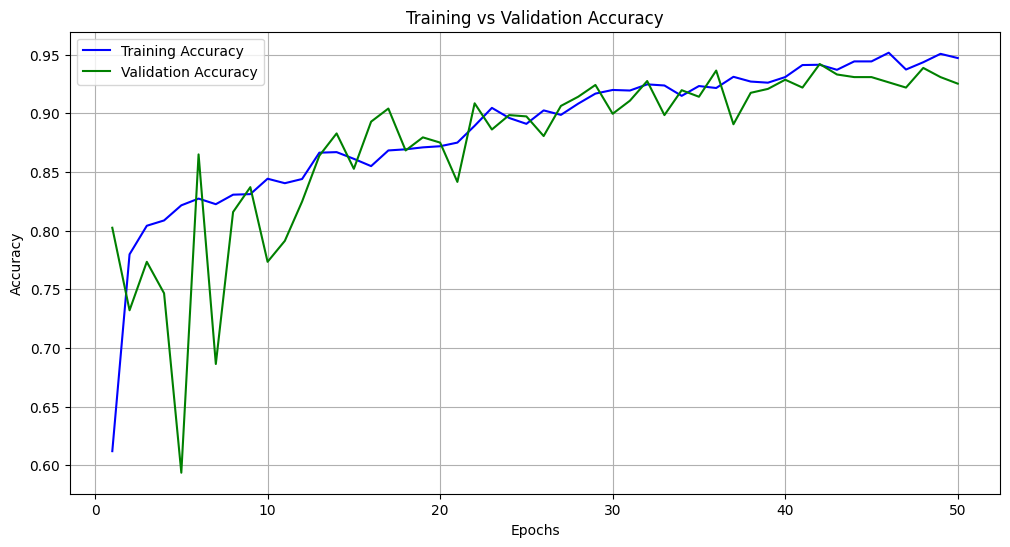

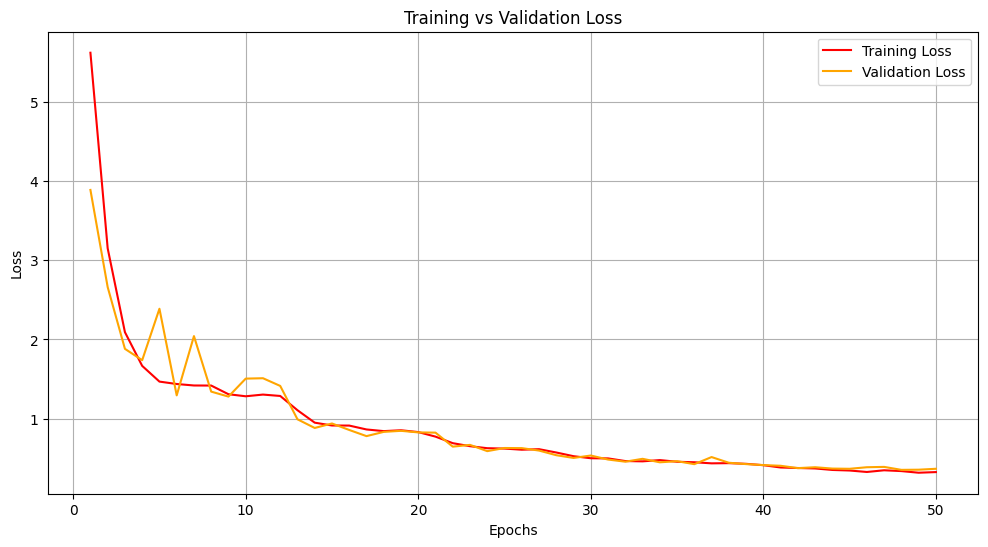

In [ ]:

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot Training vs Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='blue')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='green')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='red')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


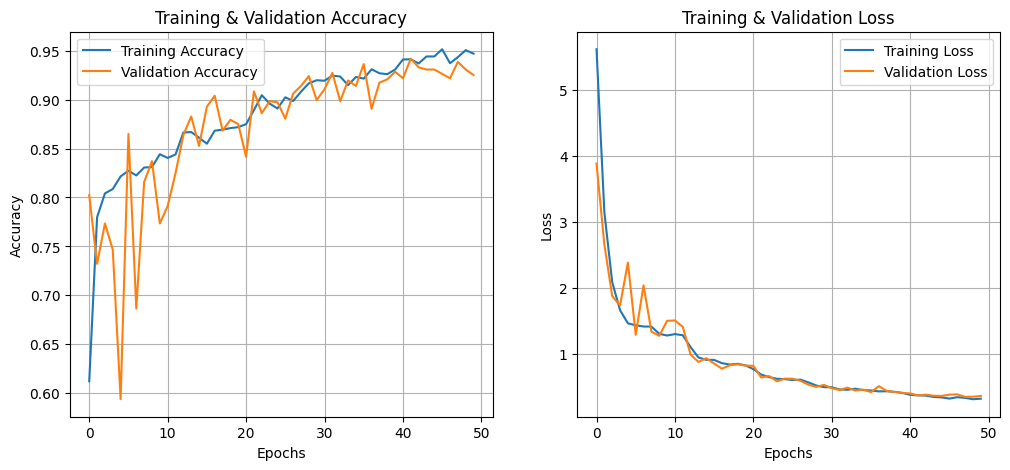

In [ ]:
# Plot Training & Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()

plt.show()


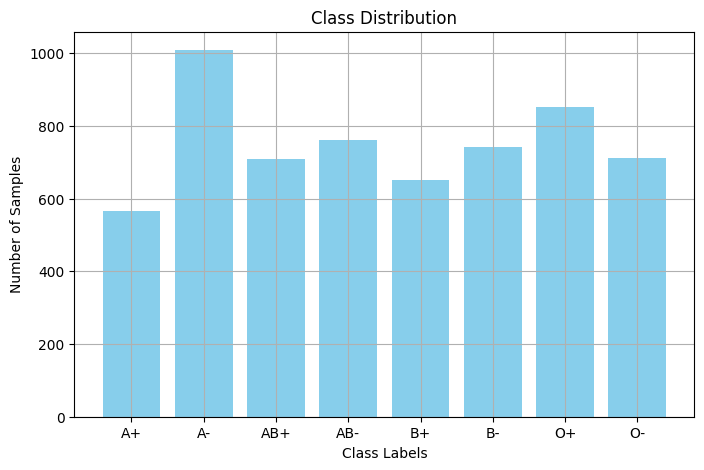

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(ticks=list(class_counts.keys()), labels=[class_names[i] for i in class_counts.keys()])
plt.grid()
plt.show()


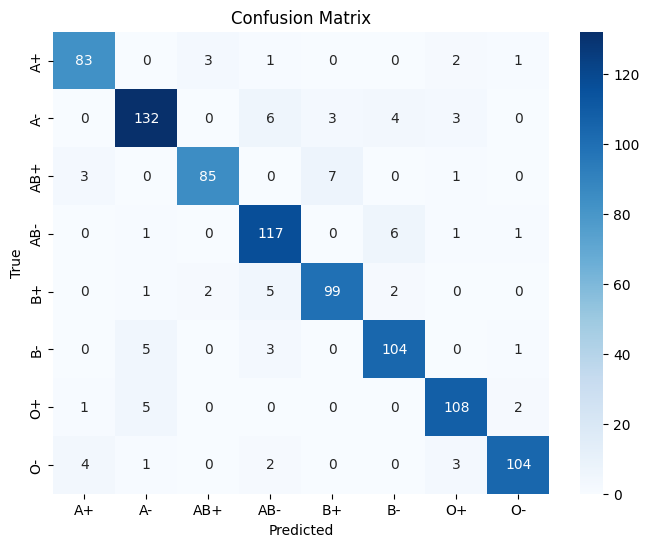

In [ ]:
# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[class_names[i] for i in unique_labels],
            yticklabels=[class_names[i] for i in unique_labels])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


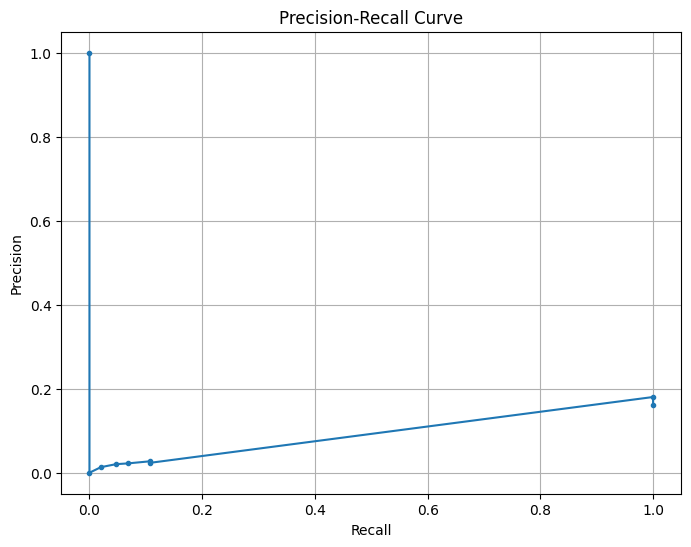

In [ ]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()


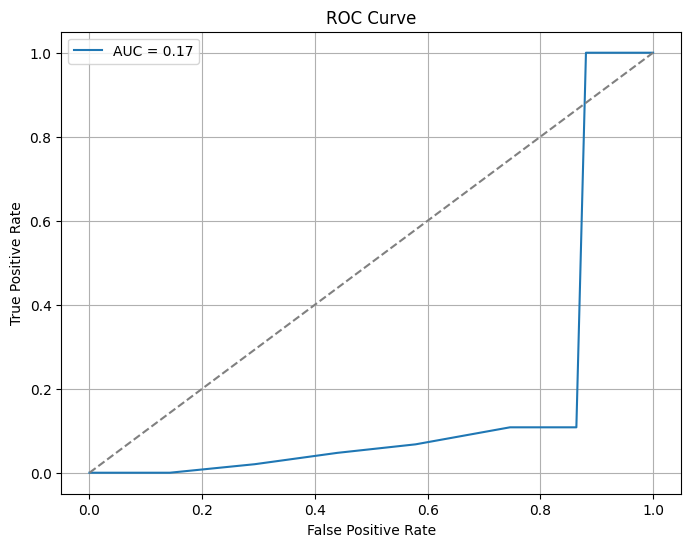

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
model_path = "blood_group_model_v2.h5"
model = tf.keras.models.load_model(model_path)
blood_groups = ["A+","A-","AB+","B+","AB-","B-","O+","O-"]

# Load and preprocess image
image_path = "Deepthi.jpg"
image = cv2.imread(image_path)

if image is None:
    print("Error: Image not found or cannot be loaded.")
else:

    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_resized = cv2.resize(image_gray, (64, 64))
    image_resized = image_resized / 255.0
    image_resized = (image_resized * 255).astype(np.uint8)
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)

    image_rgb = np.expand_dims(image_rgb, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(image_rgb)

    # Get predicted class
    predicted_blood_group = blood_groups[np.argmax(prediction)]

    print(f"Predicted Blood Group: {predicted_blood_group}")


Error: Image not found or cannot be loaded.


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

model_path = "blood_group_model_v2.h5"
model = tf.keras.models.load_model(model_path)

blood_groups = ["A+","A-","AB+","B+","AB-","B-","O+","O-"]

image_path = "sir2.jpg"
image = cv2.imread(image_path)

if image is None:
    print("Error: Image not found or cannot be loaded.")
else:

    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image_resized = cv2.resize(image_gray, (64, 64))

    image_resized = image_resized / 255.0

    image_resized = (image_resized * 255).astype(np.uint8)


    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)

    image_rgb = np.expand_dims(image_rgb, axis=0)  # Add batch dimension

    prediction = model.predict(image_rgb)

    # Get predicted class
    predicted_blood_group = blood_groups[np.argmax(prediction)]

    print(f"Predicted Blood Group: {predicted_blood_group}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Predicted Blood Group: B+


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

model_path = "blood_group_model_v2.h5"
model = tf.keras.models.load_model(model_path)

blood_groups = ["A+","A-","AB+","B+","AB-","B-","O+","O-"]

image_path = "rahul.jpg"
image = cv2.imread(image_path)

if image is None:
    print("Error: Image not found or cannot be loaded.")
else:

    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    image_resized = cv2.resize(image_gray, (64, 64))

    image_resized = image_resized / 255.0

    image_resized = (image_resized * 255).astype(np.uint8)


    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)

    image_rgb = np.expand_dims(image_rgb, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(image_rgb)

    # Get predicted class
    predicted_blood_group = blood_groups[np.argmax(prediction)]

    print(f"Predicted Blood Group: {predicted_blood_group}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Predicted Blood Group: B+


In [ ]:
import cv2
import numpy as np
import tensorflow as tf


model_path = "blood_group_model_v2.h5"
model = tf.keras.models.load_model(model_path)


blood_groups = ["A+","A-","O-","B+","AB-","B-","O+","AB+"]


image_path = "hareshwar.jpg"
image = cv2.imread(image_path)

if image is None:
    print("Error: Image not found or cannot be loaded.")
else:

    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    image_resized = cv2.resize(image_gray, (64, 64))


    image_resized = image_resized / 255.0


    image_resized = (image_resized * 255).astype(np.uint8)


    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)

    image_rgb = np.expand_dims(image_rgb, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(image_rgb)

    # Get predicted class
    predicted_blood_group = blood_groups[np.argmax(prediction)]

    print(f"Predicted Blood Group: {predicted_blood_group}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Predicted Blood Group: AB+


Class Distribution:
Class AB+: 708 images
Class O+: 852 images
Class B-: 741 images
Class AB-: 761 images
Class B+: 652 images
Class A+: 565 images
Class A-: 1009 images
Class O-: 712 images


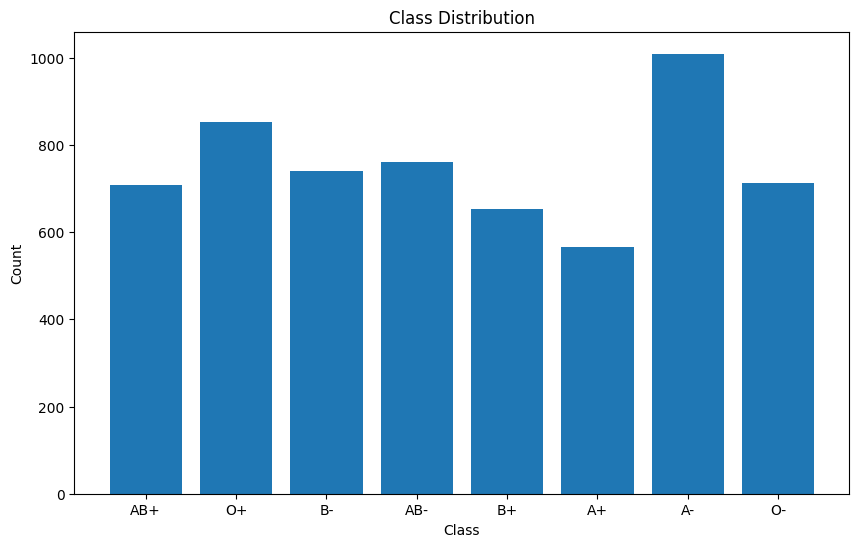

In [ ]:
# Analyze class distribution
class_names = dataset.class_names
class_counts = Counter()
for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1

print("Class Distribution:")
for i, count in class_counts.items():
    print(f"Class {class_names[i]}: {count} images")

# Plot class distribution
def plot_class_distribution(class_names, class_counts):
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(class_names, class_counts)


In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = ["A+", "A-", "B+", "B-", "O+", "O-", "AB+", "AB-"]
encoder = LabelEncoder()
encoder.fit(labels)
print(encoder.classes_)  # This will show you the order of labels


['A+' 'A-' 'AB+' 'AB-' 'B+' 'B-' 'O+' 'O-']


In [ ]:
model = tf.keras.models.load_model('blood_group_model_v2.h5')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,194,634 (8.37 MB)

 Trainable params: 2,193,672 (8.37 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 2 (12.00 B)